<a href="https://colab.research.google.com/github/Guiils/analise_de_dados/blob/main/join_df_clima_e_plotagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Preparação de bibliotecas

In [ ]:
pip install pyspark

In [ ]:
pip install gcsfs

In [ ]:

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import isnull
from pyspark.sql.types import FloatType, DoubleType, StructType, StructField, StringType, IntegerType
from functools import reduce
from google.cloud import storage
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

##Conector para Cloud Storage(bucket)

In [ ]:
#CONFIGURANDO DA CHAVE DE SEGURANCA (Enviada com o projeto)

serviceAccount = '/content/loyal-optics-377819-ebe367c145ff.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount

In [ ]:
#Configurações Google Cloud Storage
client = storage.Client()
bucket = client.get_bucket('tcc_soulcode_g3')

##Conexão Spark

In [ ]:
#configurar a variavel de ambiente (sessão)
spark = (SparkSession.builder
                     .master('local[1]')
                     .appName('juntar_dataframes')
                     .config('spark.ui.port', '4050')
                     .config("spark.jars", 'https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop2-latest.jar')
                     .getOrCreate()
)

In [ ]:
spark

## Realização dos Joins


In [ ]:
# Criando uma lista vazia para armazenar os caminhos dos arquivos
data_frames = []

# Adiciona os arquivos do GCP na lista que criei acima
for i in range(1, 44):
  # De acordo com os nome que estão no bucket vai atribuindo os caminhos a variável df
  df = f'gs://tcc_soulcode_g3/tratados_clima_mensal/sul/dados_M_2010-01-01_2022-12-31{i}_tratado.csv'
  
  data_frames.append(df)


In [ ]:
# Carrega o primeiro arquivo com base no caminho da lista para poder ter o primeiro df carregado na memória e começar a fazer os joins
dataframe = (spark.read
                   .format('csv')
                   .option('delimiter', ';') 
                  .option('header', 'true')
                  .option('encoding', 'utf-8')
                  .option('inferschema', 'true')
                  .csv(data_frames[0]))

In [ ]:
# Como o primeiro df já foi carrega esse for começa do segundo elemento da lista e vai até o ultimo
for df in data_frames[1:]:
  #Carrega o segundo elemento como temporário apenas para o loop em que é adicionado ao df completo
  temp_df = (spark.read
                  .format('csv')
                  .option('delimiter', ';') 
                  .option('header', 'true')
                  .option('encoding', 'utf-8')
                  .option('inferschema', 'true').csv(df))
  # Join é feito com a função unionByName que vai permitir juntar os dfs de forma vertical com base no nome das colunas
  dataframe = dataframe.unionByName(temp_df)

## Carregando DF completo para o GCP

In [ ]:
df_salvar = dataframe.toPandas()

In [ ]:
gcs_path = 'gs://tcc_soulcode_g3/tratados_clima_mensal/sul/sul_completo_tratado.csv'
df_salvar.to_csv(gcs_path, sep = ';', index = False)

##Importação do DF completo para realizar a padronização

In [ ]:
#IMPORTAR O DATAFRAME COMPLETO DO GCS
df_completo = (
         spark.read
         .format('csv')
         .option('delimiter', ';') 
         .option('header', 'true')
         .option('encoding', 'utf-8')
         .option('inferschema', 'true')
         .load('gs://tcc_soulcode_g3/tratados_clima_mensal/sul/sul_completo_tratado.csv')
)


In [ ]:
df_completo.show()

+------------+----------------------------+-----------------------------+----------------------------+--------------------------+--------------------------+----------+--------------------+------+
|data_medicao|dias_com_precipitacao_mensal|precipitacao_mensal_total(mm)|temperatura_media_mensal(°C)|vento_vel_max_mensal(Km/h)|vento_vel_med_mensal(Km/h)| MUNICIPIO|          COORDENADA|REGIAO|
+------------+----------------------------+-----------------------------+----------------------------+--------------------------+--------------------------+----------+--------------------+------+
|  2011-12-31|                        13.0|                         48.2|                   20.835618|        42.480000000000004|                14.6400012|RIO GRANDE|-32.07888888, -52...|   SUL|
|  2013-06-30|                        17.0|                        128.4|                   13.305051|                     33.84|                  9.131544|RIO GRANDE|-32.07888888, -52...|   SUL|
|  2022-09-30|      

Renomeando Colunas e adicionando a coluna Sul para consultas direcionadas no dashboard

In [ ]:
df_completo = df_completo.withColumn('REGIAO', F.lit('SUL'))

In [ ]:
df_completo = (df_completo.withColumnRenamed('Data Medicao','data_medicao')
   .withColumnRenamed('NUMERO DE DIAS COM PRECIPITACAO PLUV - MENSAL (AUT)(numero)','dias_com_precipitacao_mensal')
   .withColumnRenamed('PRECIPITACAO TOTAL - MENSAL (AUT)(mm)','precipitacao_mensal_total(mm)')
   .withColumnRenamed('TEMPERATURA MEDIA - MENSAL (AUT)(°C)','temperatura_media_mensal(°C)')
   .withColumnRenamed('VENTO - VELOCIDADE MAXIMA MENSAL (AUT)(Km/h)','vento_vel_max_mensal(Km/h)')
   .withColumnRenamed('VENTO - VELOCIDADE MEDIA MENSAL (AUT)(Km/h)','vento_vel_med_mensal(Km/h)'))

##Load(Carregando o df completo da região Sul para o bucket no GCP)

Salvar no gcp com separador ';'

In [ ]:
df_salvar = df_completo.toPandas()

In [ ]:
gcs_path = 'gs://tcc_soulcode_g3/tratados_clima_mensal/sul/sul_completo_com_regiao_tratado.csv'
df_salvar.to_csv(gcs_path, sep = ';', index = False)

Salvar no gcp com separador ','

In [ ]:
df_salvar = df_completo.toPandas()

In [ ]:
gcs_path = 'gs://tcc_soulcode_g3/tratados_clima_mensal/sul/sul_completo_looker_tratado.csv'
df_salvar.to_csv(gcs_path, sep = ',', index = False)

#Plotagem

##Join e formatação do df para as plotagens

In [ ]:
#IMPORTAR O DATAFRAME COMPLETO DAS REGIÕES
df_plot_clima = (
         spark.read
         .format('csv')
         .option('delimiter', ';') 
         .option('header', 'true')
         .option('encoding', 'utf-8')
         .option('inferschema', 'true')
         .load('gs://tcc_soulcode_g3/tratados_clima_mensal/centro_oeste_sul_completo_tratado_power.csv')
)


In [ ]:
#IMPORTAR O DATAFRAME COMPLETO DE PRODUÇÕES
df_plot_prod = (
         spark.read
         .format('csv')
         .option('delimiter', ',') 
         .option('header', 'true')
         .option('encoding', 'utf-8')
         .option('inferschema', 'true')
         .load('gs://tcc_soulcode_g3/tratados_producao/Tratado_Producao_Unidos.csv')
)

In [ ]:
df_plot_clima.show()

+----------+----------------------------+-----------------------------+----------------------------+--------------------------+--------------------------+---------+--------------------+------------+
|   periodo|dias_com_precipitacao_mensal|precipitacao_mensal_total(mm)|temperatura_media_mensal(°C)|vento_vel_max_mensal(Km/h)|vento_vel_med_mensal(Km/h)|MUNICIPIO|          COORDENADA|      REGIAO|
+----------+----------------------------+-----------------------------+----------------------------+--------------------------+--------------------------+---------+--------------------+------------+
|2022-12-01|                        22.0|                        322.6|                   20.817876|                     19.08|                  8.038548| BRASILIA|-15.78944444, -47...|CENTRO OESTE|
|2011-09-01|                         2.0|                          6.4|                    23.22375|                     25.56|                    10.647| BRASILIA|-15.78944444, -47...|CENTRO OESTE|
|2015

In [ ]:
df_plot_prod.show()

+--------------------+----------+-----------+----------+-------------------+
|           definicao|   periodo|commodities|regiao_sul|regiao_centro_oeste|
+--------------------+----------+-----------+----------+-------------------+
|Variável - Área p...|01/01/2010|      Total|  19584077|           16943884|
|Variável - Área p...|01/01/2010|     Feijão|    478556|              74852|
|Variável - Área p...|01/01/2010|     Feijão|    335541|              69552|
|Variável - Área p...|01/01/2010|     Feijão|      5642|              50159|
|Variável - Área p...|01/01/2010|      Milho|   2665628|             577046|
|Variável - Área p...|01/01/2010|      Milho|   1509289|            2794213|
|Variável - Área p...|01/01/2010|       Soja|   8815126|           10401950|
|Variável - Área p...|01/02/2010|      Total|  19395077|           16905181|
|Variável - Área p...|01/02/2010|     Feijão|    479022|              74720|
|Variável - Área p...|01/02/2010|     Feijão|    258908|              69552|

In [ ]:
df_plot_clima = df_plot_clima.drop('dias_com_precipitacao_mensal','temperatura_media_mensal(°C)','vento_vel_max_mensal(Km/h)','vento_vel_med_mensal(Km/h)','MUNICIPIO','COORDENADA')

In [ ]:
df_plot_clima.show()

+----------+-----------------------------+------------+
|   periodo|precipitacao_mensal_total(mm)|      REGIAO|
+----------+-----------------------------+------------+
|2022-12-01|                        322.6|CENTRO OESTE|
|2011-09-01|                          6.4|CENTRO OESTE|
|2015-02-01|                        115.4|CENTRO OESTE|
|2016-01-01|                        345.0|CENTRO OESTE|
|2015-12-01|                        153.2|CENTRO OESTE|
|2010-09-01|                          0.0|CENTRO OESTE|
|2011-04-01|                         59.8|CENTRO OESTE|
|2019-10-01|                         22.8|CENTRO OESTE|
|2021-03-01|                        164.0|CENTRO OESTE|
|2017-05-01|                         64.2|CENTRO OESTE|
|2012-06-01|                          2.4|CENTRO OESTE|
|2015-05-01|                         43.8|CENTRO OESTE|
|2016-11-01|                        248.4|CENTRO OESTE|
|2020-10-01|                        165.6|CENTRO OESTE|
|2011-03-01|                        231.2|CENTRO

In [ ]:
df_plot_clima.printSchema()

root
 |-- periodo: date (nullable = true)
 |-- precipitacao_mensal_total(mm): double (nullable = true)
 |-- REGIAO: string (nullable = true)



In [ ]:
df_plot_prod.printSchema()

root
 |-- definicao: string (nullable = true)
 |-- periodo: string (nullable = true)
 |-- commodities: string (nullable = true)
 |-- regiao_sul: string (nullable = true)
 |-- regiao_centro_oeste: string (nullable = true)



In [ ]:
df_plot_prod = df_plot_prod.withColumn('periodo', F.to_date(F.col('periodo'), 'dd/MM/yyyy'))
df_plot_prod = df_plot_prod.withColumn("regiao_sul", F.col("regiao_sul").cast("double"))
df_plot_prod = df_plot_prod.withColumn("regiao_centro_oeste", F.col("regiao_centro_oeste").cast("double"))
df_plot_prod = df_plot_prod.withColumnRenamed("periodo", "prod_periodo")

In [ ]:
df_plot = df_plot_prod.join(df_plot_clima, df_plot_prod["prod_periodo"] == df_plot_clima["periodo"], "inner")

In [ ]:
df_plot.show(truncate = False)

+-----------------------------------------------------+------------+-----------+-----------+-------------------+----------+-----------------------------+------------+
|definicao                                            |prod_periodo|commodities|regiao_sul |regiao_centro_oeste|periodo   |precipitacao_mensal_total(mm)|REGIAO      |
+-----------------------------------------------------+------------+-----------+-----------+-------------------+----------+-----------------------------+------------+
|Variável - Rendimento médio (Quilogramas por Hectare)|2022-12-01  |Soja       |1867.0     |3318.0             |2022-12-01|322.6                        |CENTRO OESTE|
|Variável - Rendimento médio (Quilogramas por Hectare)|2022-12-01  |Milho      |4887.0     |5762.0             |2022-12-01|322.6                        |CENTRO OESTE|
|Variável - Rendimento médio (Quilogramas por Hectare)|2022-12-01  |Milho      |5243.0     |7954.0             |2022-12-01|322.6                        |CENTRO OESTE

In [ ]:
df_plot.count()

274288

In [ ]:
df_plot = df_plot.filter(F.col("commodities") != 'Total')

In [ ]:
df_plot = df_plot.filter(F.col('definicao') == 'Variável - Produção (Toneladas)')

In [ ]:
df_plot_rend = df_plot.filter(F.col('definicao') == 'Variável - Rendimento médio (Quilogramas por Hectare)')

In [ ]:
df_plot.count()

58776

In [ ]:
df_plot.show()

+--------------------+------------+-----------+-----------+-------------------+----------+-----------------------------+------------+
|           definicao|prod_periodo|commodities| regiao_sul|regiao_centro_oeste|   periodo|precipitacao_mensal_total(mm)|      REGIAO|
+--------------------+------------+-----------+-----------+-------------------+----------+-----------------------------+------------+
|Variável - Produç...|  2022-12-01|       Soja|2.3690251E7|        6.1914788E7|2022-12-01|                        322.6|CENTRO OESTE|
|Variável - Produç...|  2022-12-01|      Milho|  1.32947E7|        6.0588105E7|2022-12-01|                        322.6|CENTRO OESTE|
|Variável - Produç...|  2022-12-01|      Milho|  8076867.0|          2217306.0|2022-12-01|                        322.6|CENTRO OESTE|
|Variável - Produç...|  2022-12-01|     Feijão|      800.0|           342890.0|2022-12-01|                        322.6|CENTRO OESTE|
|Variável - Produç...|  2022-12-01|     Feijão|   697395.0|   

In [ ]:
df_plot = df_plot.drop('prod_periodo')
df_plot_rend = df_plot_rend.drop('prod_periodo')

In [ ]:
df_plot = df_plot.withColumnRenamed("precipitacao_mensal_total(mm)", "precipitacao_mensal_total")
df_plot_rend = df_plot_rend.withColumnRenamed("precipitacao_mensal_total(mm)", "precipitacao_mensal_total")

In [ ]:
df_plot = df_plot.drop_duplicates()
df_plot_rend = df_plot_rend.drop_duplicates()

In [ ]:
df_plot.show(truncate = False)

+-------------------------------+-----------+-----------+-------------------+----------+-------------------------+------------+
|definicao                      |commodities|regiao_sul |regiao_centro_oeste|periodo   |precipitacao_mensal_total|REGIAO      |
+-------------------------------+-----------+-----------+-------------------+----------+-------------------------+------------+
|Variável - Produção (Toneladas)|Milho      |1.3118839E7|4527046.0          |2012-01-01|248.8                    |CENTRO OESTE|
|Variável - Produção (Toneladas)|Feijão     |710482.0   |157466.0           |2010-03-01|225.6                    |CENTRO OESTE|
|Variável - Produção (Toneladas)|Soja       |4.2599367E7|6.0819956E7        |2021-08-01|9.4                      |CENTRO OESTE|
|Variável - Produção (Toneladas)|Feijão     |507627.0   |299839.0           |2015-04-01|133.2                    |CENTRO OESTE|
|Variável - Produção (Toneladas)|Feijão     |478050.0   |295808.0           |2016-02-01|152.6           

In [ ]:
df_plot.count()

248472

##Plots Região Sul

In [ ]:
df_plot_sul = df_plot.filter(F.col('REGIAO') == 'SUL')
df_plot_sul_rend = df_plot_rend.filter(F.col('REGIAO') == 'SUL')

Plotagem de Produção(Toneladas)

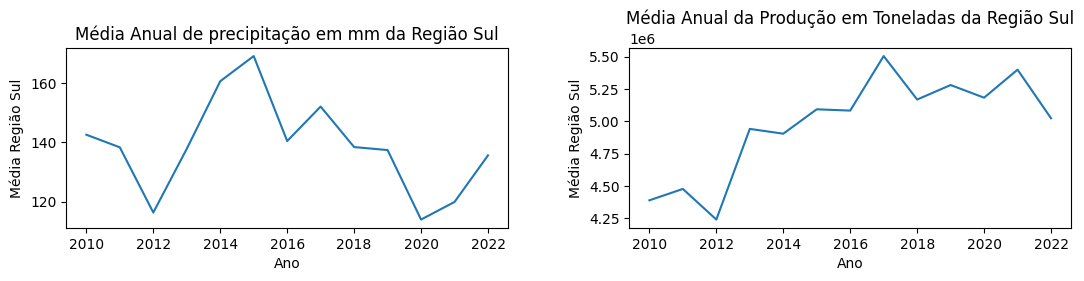

In [ ]:
df_plot_pd_sul = df_plot_sul.toPandas()

# Fazendo conversão da coluna 'periodo' para o tipo datetime
df_plot_pd_sul['periodo'] = pd.to_datetime(df_plot_pd_sul['periodo'])

# Agregar a média anual da coluna 'precipitacao_mensal_total'
df_agg = df_plot_pd_sul.groupby(df_plot_pd_sul['periodo'].dt.year)['precipitacao_mensal_total'].mean().reset_index()

# Agregar a média anual da coluna 'regiao_sul' que corresponde a produção de grãos
df_agg_prod = df_plot_pd_sul.groupby(df_plot_pd_sul['periodo'].dt.year)['regiao_sul'].mean().reset_index()

# Criar os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Criando o gráfico de Média Anual de precipitação em mm da Região Sul
axs[0].plot(df_agg['periodo'], df_agg['precipitacao_mensal_total'])
axs[0].set_xlabel('Ano')
axs[0].set_ylabel('Média Região Sul')
axs[0].set_title('Média Anual de precipitação em mm da Região Sul')


# Criando o gráfico de Média Anual da Produção em Toneladas da Região Sul
axs[1].plot(df_agg_prod['periodo'], df_agg_prod['regiao_sul'])
axs[1].set_xlabel('Ano')
axs[1].set_ylabel('Média Região Sul')
axs[1].set_title('Média Anual da Produção em Toneladas da Região Sul')

# Ajustar o espaçamento entre os subplots através do pad que dita a distancia de um gráfico para o outro
plt.tight_layout(pad = 5)

# Exibir os gráficos
plt.show()

Plotagem de Rendimento de Grãos (Kg/ha)

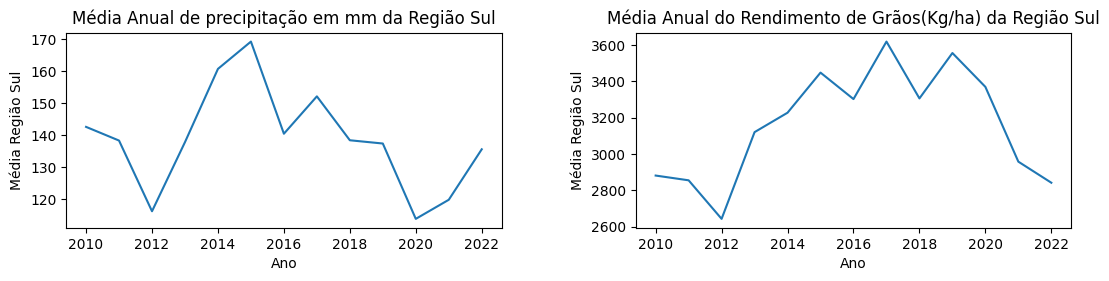

In [ ]:
df_plot_pd_sul_rend = df_plot_sul_rend.toPandas()

# Fazendo conversão da coluna 'periodo' para o tipo datetime
df_plot_pd_sul_rend['periodo'] = pd.to_datetime(df_plot_pd_sul_rend['periodo'])

# Agregar a média anual da coluna 'precipitacao_mensal_total'
df_agg = df_plot_pd_sul_rend.groupby(df_plot_pd_sul_rend['periodo'].dt.year)['precipitacao_mensal_total'].mean().reset_index()

# Agregar a média anual da coluna 'regiao_sul' que corresponde ao Rendimento de grãos(Kg/ha)
df_agg_prod = df_plot_pd_sul_rend.groupby(df_plot_pd_sul_rend['periodo'].dt.year)['regiao_sul'].mean().reset_index()

# Criar os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Criando o gráfico de Média Anual de precipitação em mm da Região Sul
axs[0].plot(df_agg['periodo'], df_agg['precipitacao_mensal_total'])
axs[0].set_xlabel('Ano')
axs[0].set_ylabel('Média Região Sul')
axs[0].set_title('Média Anual de precipitação em mm da Região Sul')


# Criando o gráfico de Média Anual do Rendimento de Grãos(Kg/ha) da Região Sul
axs[1].plot(df_agg_prod['periodo'], df_agg_prod['regiao_sul'])
axs[1].set_xlabel('Ano')
axs[1].set_ylabel('Média Região Sul')
axs[1].set_title('Média Anual do Rendimento de Grãos(Kg/ha) da Região Sul')

# Ajustar o espaçamento entre os subplots através do pad que dita a distancia de um gráfico para o outro
plt.tight_layout(pad = 5)

# Exibir os gráficos
plt.show()

##Plots Crentro-Oeste

In [ ]:
df_plot_co = df_plot.filter(F.col('REGIAO') == 'CENTRO OESTE')
df_plot_co_rend = df_plot_rend.filter(F.col('REGIAO') == 'CENTRO OESTE')

Plotagem de Produção(Toneladas)

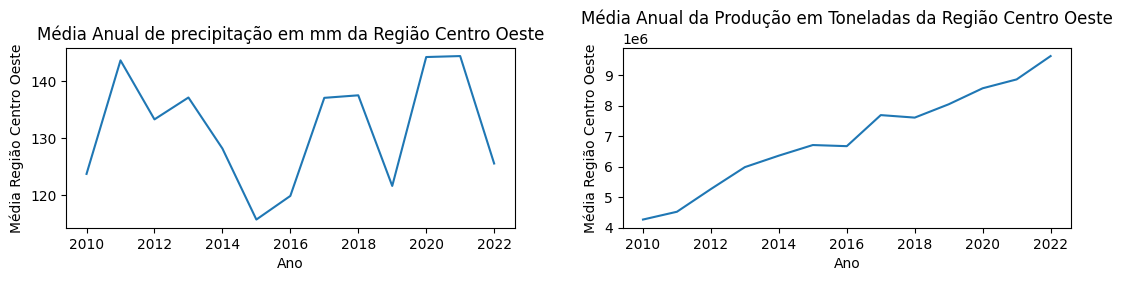

In [ ]:
df_plot_pd_co = df_plot_co.toPandas()

# Fazendo conversão da coluna 'periodo' para o tipo datetime
df_plot_pd_co['periodo'] = pd.to_datetime(df_plot_pd_co['periodo'])

# Agregar a média anual da coluna 'precipitacao_mensal_total'
df_agg = df_plot_pd_co.groupby(df_plot_pd_co['periodo'].dt.year)['precipitacao_mensal_total'].mean().reset_index()

# Agregar a média anual da coluna 'regiao_centro_oeste' que corresponde a produção de grãos
df_agg_prod = df_plot_pd_co.groupby(df_plot_pd_co['periodo'].dt.year)['regiao_centro_oeste'].mean().reset_index()

# Criar os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Criando o gráfico de Média Anual de precipitação em mm da Região Sul
axs[0].plot(df_agg['periodo'], df_agg['precipitacao_mensal_total'])
axs[0].set_xlabel('Ano')
axs[0].set_ylabel('Média Região Centro Oeste')
axs[0].set_title('Média Anual de precipitação em mm da Região Centro Oeste')


# Criando o gráfico de Média Anual da Produção em Toneladas da Região Centro Oeste
axs[1].plot(df_agg_prod['periodo'], df_agg_prod['regiao_centro_oeste'])
axs[1].set_xlabel('Ano')
axs[1].set_ylabel('Média Região Centro Oeste')
axs[1].set_title('Média Anual da Produção em Toneladas da Região Centro Oeste')

# Ajustar o espaçamento entre os subplots através do pad que dita a distancia de um gráfico para o outro
plt.tight_layout(pad = 5)

# Exibir os gráficos
plt.show()

Plotagem de Rendimento de Grãos (Kg/ha)

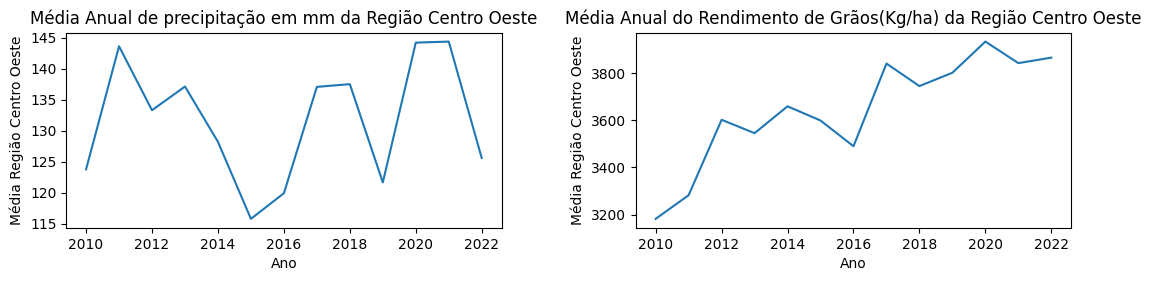

In [ ]:
df_plot_pd_co_rend = df_plot_co_rend.toPandas()

# Fazendo conversão da coluna 'periodo' para o tipo datetime
df_plot_pd_co_rend['periodo'] = pd.to_datetime(df_plot_pd_co_rend['periodo'])

# Agregar a média anual da coluna 'precipitacao_mensal_total'
df_agg = df_plot_pd_co_rend.groupby(df_plot_pd_co_rend['periodo'].dt.year)['precipitacao_mensal_total'].mean().reset_index()

# Agregar a média anual da coluna 'regiao_centro_oeste' que corresponde ao Rendimento de grãos(Kg/ha)
df_agg_prod = df_plot_pd_co_rend.groupby(df_plot_pd_co_rend['periodo'].dt.year)['regiao_centro_oeste'].mean().reset_index()

# Criar os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Criando o gráfico de Média Anual de precipitação em mm da Região Centro Oeste
axs[0].plot(df_agg['periodo'], df_agg['precipitacao_mensal_total'])
axs[0].set_xlabel('Ano')
axs[0].set_ylabel('Média Região Centro Oeste')
axs[0].set_title('Média Anual de precipitação em mm da Região Centro Oeste')


# Criando o gráfico de Média Anual do Rendimento de Grãos(Kg/ha) da Região Centro Oeste
axs[1].plot(df_agg_prod['periodo'], df_agg_prod['regiao_centro_oeste'])
axs[1].set_xlabel('Ano')
axs[1].set_ylabel('Média Região Centro Oeste')
axs[1].set_title('Média Anual do Rendimento de Grãos(Kg/ha) da Região Centro Oeste')

# Ajustar o espaçamento entre os subplots através do pad que dita a distancia de um gráfico para o outro
plt.tight_layout(pad = 5)

# Exibir os gráficos
plt.show()